In [1]:
import pandas as pd
import numpy as np
import pickle
import joblib
### 모델링--------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, accuracy_score, roc_auc_score
# 업샘플링
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
### 새로운 데이터 --------------------
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.preprocessing import LabelEncoder
### XAI ----------------------------
import shap
from scipy.special import inv_boxcox
# 시각화
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False
import matplotlib.font_manager as fm
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

#### SHAP - 기존 데이터

In [27]:
### 모델 로드
model_path = model_path = '/content/drive/MyDrive/세은/model.pickle'
xgb_model = joblib.load(model_path)

# 모델 만들 때 사용한 x
x_train_up = pd.read_csv("/content/drive/MyDrive/세은/X_train.csv", encoding = "utf-8-sig")

# 살펴볼 데이터
x_test = pd.read_csv("/content/drive/MyDrive/준희/Report/Files/x_test.csv", encoding = "utf-8-sig")
x_test.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [28]:
pothole = pd.read_csv('/content/drive/MyDrive/DATA_완성/pothole_예측용.csv')
pothole['발생여부'] = np.where(pothole['포트홀 갯수'] >=1, 1, 0)

x = pothole[['차선수', '승용차', '버스', '트럭', '총교통량', '중대형차량 교통량', '평균_건물연령', '인구 수', '배수등급', '경사도']]
x_test = x.sample(n = 4500)

In [4]:
print(x_train_up.shape)
print(x_test.shape)  # SHAP에 전달한 데이터

(13564, 10)
(4500, 10)


In [29]:
### SHAP
shap_explainer = shap.Explainer(xgb_model, x_train_up)
shap_values_ex = shap_explainer(x_test) # 각 SHAP value에 대한 정보를 담은 Explainer
# Explainer 살펴보기
print("SHAP values 크기 : ", np.array(shap_values_ex).shape) # (# x_test 데이터, # 변수들)

100%|===================| 4479/4500 [03:13<00:00]       

SHAP values 크기 :  (4500, 10)


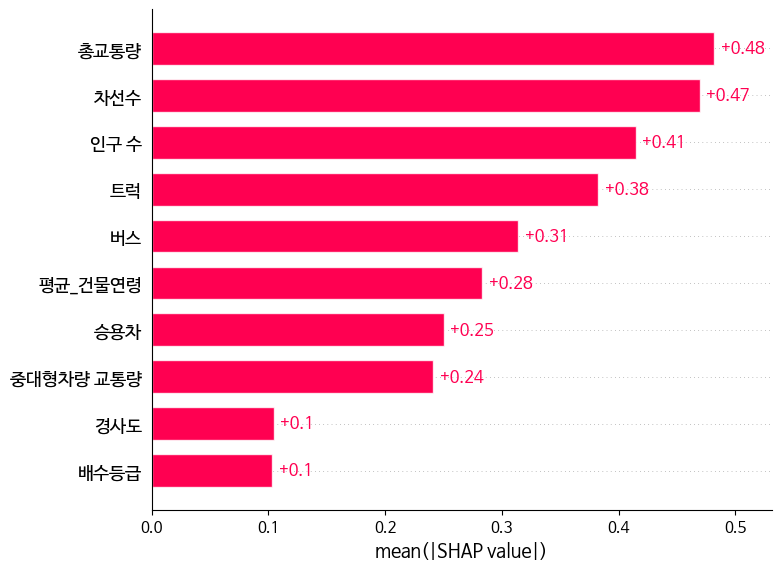

In [30]:
# 전체 feature importance
shap.plots.bar(shap_values_ex)
shap.plots.bar(shap_values_ex, show=False)  # show=False로 plt에 그리기만 함
plt.title("전체 Feature Importance", fontsize=16, loc='center')
plt.savefig("전체 feature importance.png", bbox_inches='tight', dpi=300)
plt.close()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


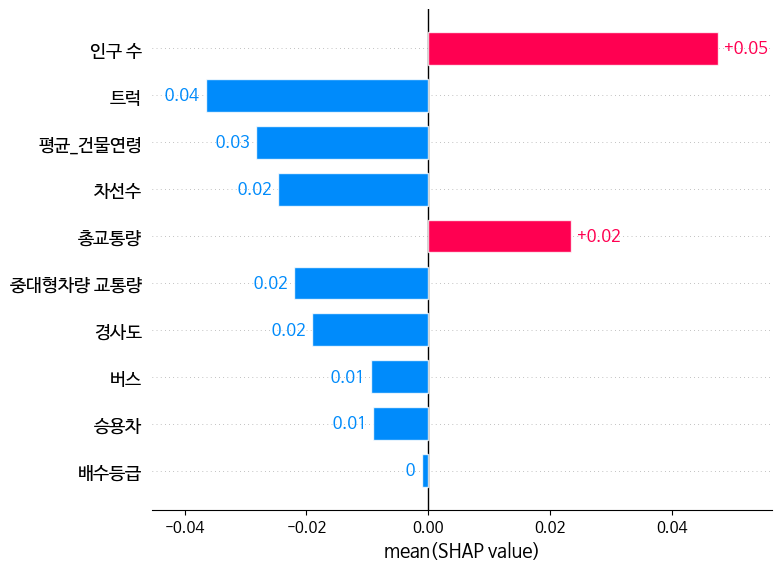

<ipython-input-31-e88f94732dbc>:5: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.savefig("평균 feature importance.png", bbox_inches='tight', dpi=300)


In [31]:
# 평균 feature importance
shap.plots.bar(shap_values_ex.mean(axis = 0))
shap.plots.bar(shap_values_ex.mean(axis = 0), show=False)  # show=False로 plt에 그리기만 함
plt.title("평균 Feature Importance", fontsize=16, loc='center')
plt.savefig("평균 feature importance.png", bbox_inches='tight', dpi=300)
plt.close()

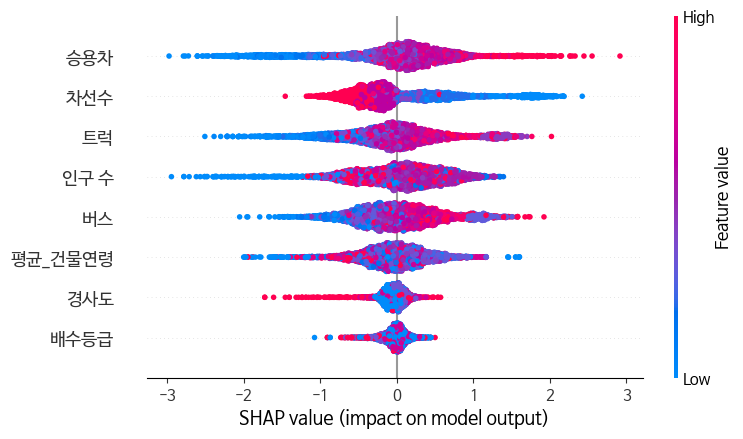

In [ ]:
# 전체 분포 (beeswarm)
shap.plots.beeswarm(shap_values_ex)


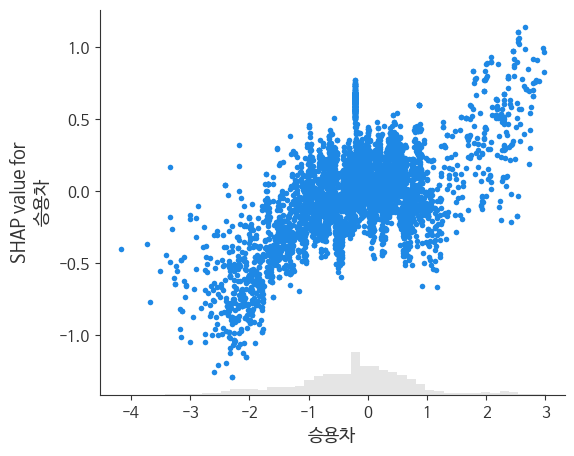

In [32]:
# 특정 feature 하나 (scatter)
shap.plots.scatter(shap_values_ex[:, "승용차"])
shap.plots.scatter(shap_values_ex[:, "승용차"], show=False)  # show=False로 plt에 그리기만 함
plt.title("승용차의 Feature Importance", fontsize=16, loc='center')
plt.savefig("승용차 feature importance.png", bbox_inches='tight', dpi=300)
plt.close()

#### SHAP - 새로운 데이터

In [18]:
### 모델 로드
model_path = model_path = '/content/drive/MyDrive/세은/model.pickle'
xgb_model = joblib.load(model_path)

# 모델 만들 때 사용한 x
x_train_up = pd.read_csv("/content/drive/MyDrive/세은/X_train.csv", encoding = "utf-8-sig")

### 살펴볼 데이터 로드
new_places = pd.read_csv("/content/drive/MyDrive/준희/Report/Files/new_places_x_pres.csv", encoding = "utf-8-sig")
new_places.drop(['Unnamed: 0'], axis = 1, inplace = True)
new_places_org = pd.read_csv("/content/drive/MyDrive/준희/Report/Files/new_places_org_pres.csv", encoding = "utf-8-sig")

In [22]:
new_places_x = new_places.iloc[[0]]
new_places_x

,차선수,승용차,버스,트럭,총교통량,중대형차량 교통량,평균_건물연령,인구 수,배수등급,경사도
0,6,0.312042,0.869574,-0.239991,0.282995,-0.446776,-0.503202,-0.419831,2,1


In [23]:
### SHAP
shap_explainer = shap.Explainer(xgb_model, x_train_up)
shap_values_ex = shap_explainer(new_places_x) # 각 SHAP value에 대한 정보를 담은 Explainer
# Explainer 살펴보기
print("SHAP values 크기 : ", np.array(shap_values_ex).shape) # (# 새로운 데이터, # 변수들)

SHAP values 크기 :  (1, 10)


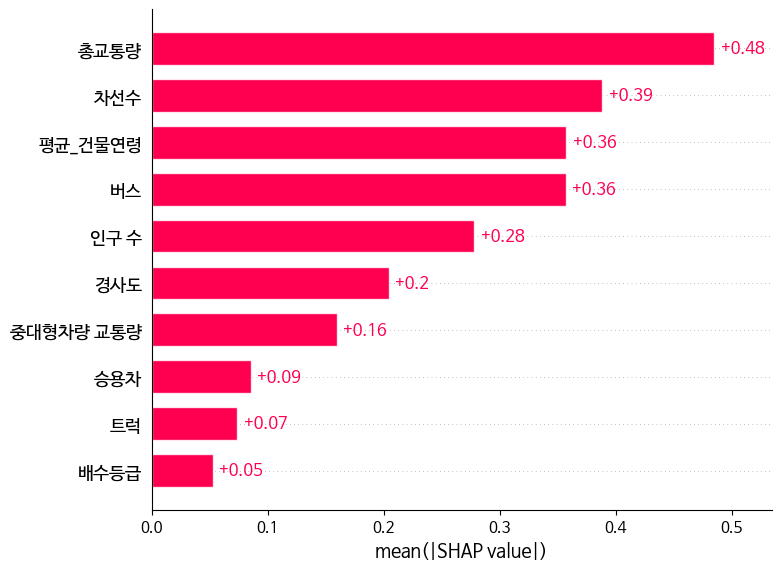

In [24]:
# 전체 feature importance
shap.plots.bar(shap_values_ex)
shap.plots.bar(shap_values_ex, show=False)  # show=False로 plt에 그리기만 함
plt.title("전체 Feature Importance", fontsize=16, loc='center')
plt.savefig("전체 feature importance_개별.png", bbox_inches='tight', dpi=300)
plt.close()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


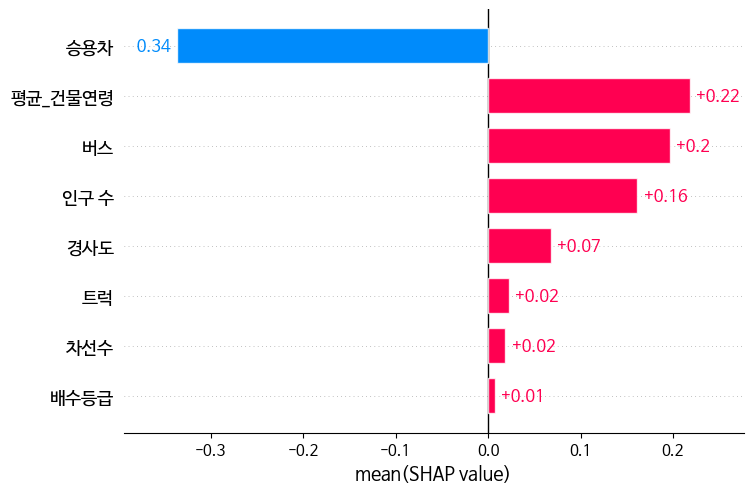

In [ ]:
# 평균 feature importance
shap.plots.bar(shap_values_ex.mean(axis = 0))

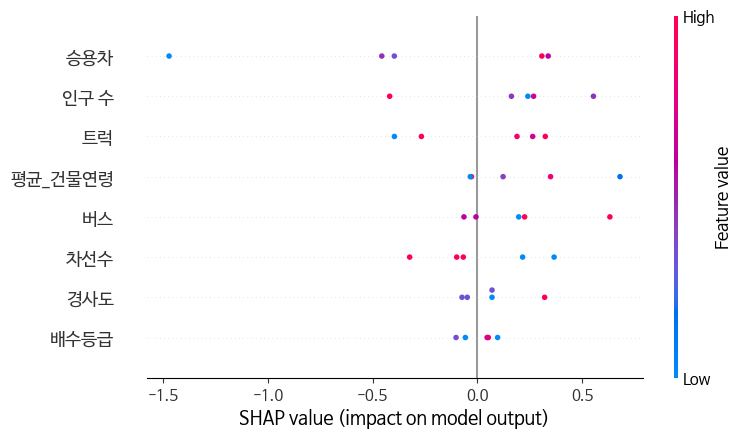

In [ ]:
# 전체 분포 (beeswarm)
shap.plots.beeswarm(shap_values_ex)

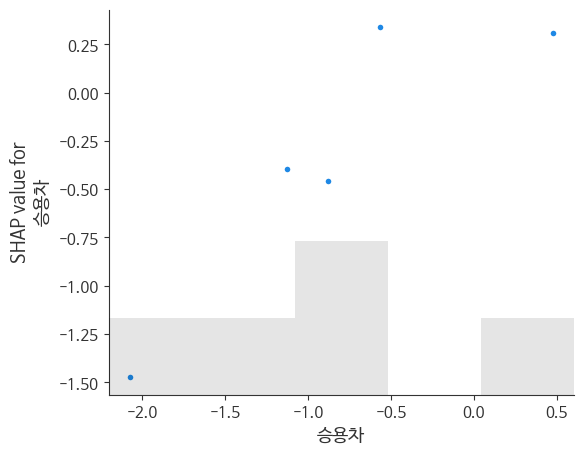

In [ ]:
# 특정 feature 하나 (scatter)
shap.plots.scatter(shap_values_ex[:, "승용차"])

/usr/local/lib/python3.11/dist-packages/shap/plots/_waterfall.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  text_bbox = txt_obj.get_window_extent(renderer=renderer)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


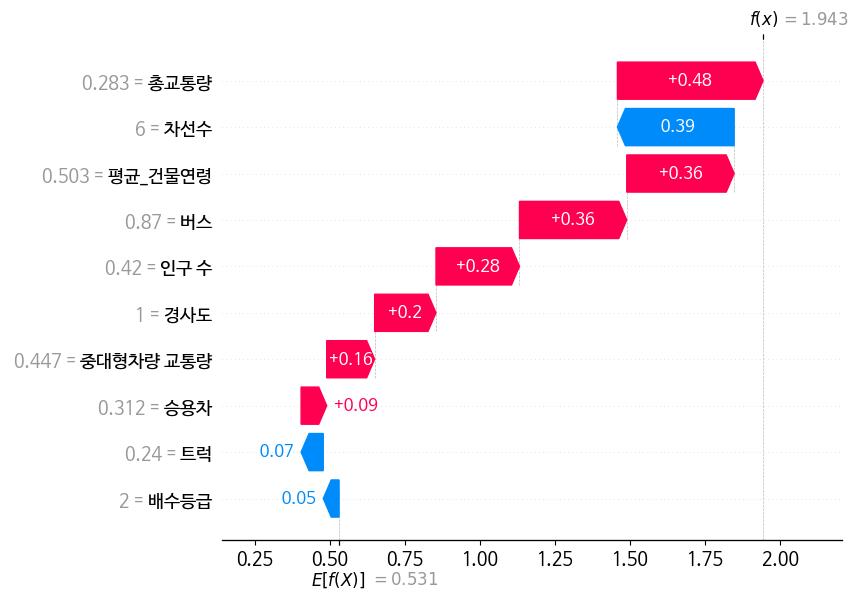

/usr/local/lib/python3.11/dist-packages/shap/plots/_waterfall.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  text_bbox = txt_obj.get_window_extent(renderer=renderer)
<ipython-input-26-95994e39c71d>:5: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.savefig("평균 feature importance_개별.png", bbox_inches='tight', dpi=300)


In [26]:
# 특정 샘플 설명 - 0번째 샘플에 대한 각 변수들의 기여도
shap.plots.waterfall(shap_values_ex[0])
shap.plots.waterfall(shap_values_ex[0], show=False)  # show=False로 plt에 그리기만 함
plt.title("평균 Feature Importance", fontsize=16, loc='center')
plt.savefig("평균 feature importance_개별.png", bbox_inches='tight', dpi=300)
plt.close()